# IMPORT ALL RELEVANT LIBRARIES

In [24]:
# ------- [Import all relevant libraries] -------

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Usual Suspects
import numpy as np           # Mathematical operations
import pandas as pd          # Data manipulation

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# String manipulation
import re

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# ML
# Models
import xgboost as xgb
import lightgbm as lgb

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Ridge

# ML Model Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Time Series
!pip install optuna
import optuna

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

!pip install catboost
from catboost import CatBoostRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Display settings
pd.set_option('display.max_colwidth', None)
from IPython.display import display

# LOAD DATA AND DO QUICK IDE

In [ ]:
data = pd.read_csv("../Clean Data/data_no_feature_engineering.csv")
data.head()

# Create a copy
df = data.copy(deep=True)

In [26]:
df.shape

(79488, 14)

In [27]:
df.columns

Index(['country_name', 'managing_agency_name',
       'managing_subagency_or_bureau_name',
       'implementing_partner_category_name', 'implementing_partner_name',
       'us_category_name', 'us_sector_name', 'funding_agency_name',
       'foreign_assistance_objective_name', 'transaction_type_name',
       'fiscal_year', 'transaction_date', 'current_dollar_amount',
       'constant_dollar_amount'],
      dtype='object')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79488 entries, 0 to 79487
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country_name                        79488 non-null  object 
 1   managing_agency_name                79488 non-null  object 
 2   managing_subagency_or_bureau_name   79488 non-null  object 
 3   implementing_partner_category_name  79488 non-null  object 
 4   implementing_partner_name           79488 non-null  object 
 5   us_category_name                    79488 non-null  object 
 6   us_sector_name                      79488 non-null  object 
 7   funding_agency_name                 79488 non-null  object 
 8   foreign_assistance_objective_name   79488 non-null  object 
 9   transaction_type_name               79488 non-null  object 
 10  fiscal_year                         79488 non-null  int64  
 11  transaction_date                    79488

In [29]:
df.duplicated().sum()

np.int64(271)

In [30]:
df.drop_duplicates(inplace=True)

In [31]:
df.isna().sum()

,0
country_name,0
managing_agency_name,0
managing_subagency_or_bureau_name,0
implementing_partner_category_name,0
implementing_partner_name,0
us_category_name,0
us_sector_name,0
funding_agency_name,0
foreign_assistance_objective_name,0
transaction_type_name,0


In [32]:
# # Check for outliers
# plt.figure(figsize=(7, 4))
# sns.boxplot(data=df, palette="Set2", linewidth=1.2)
# plt.title("Outlier Summary")
# plt.xticks(rotation=0, ha="center")
# plt.tight_layout()
# plt.show()


# DATA WRANGLING

In [33]:
# Columns to drop
cols_to_drop = [
    'country_name',
    'transaction_date',
    'current_dollar_amount',
    'implementing_partner_name',
    'managing_subagency_or_bureau_name',
    'implementing_partner_category_name',
    'foreign_assistance_objective_name'
]

# Drop
df = df.drop(columns=cols_to_drop)
print("Remaining columns:")
display(df.columns)


Remaining columns:


Index(['managing_agency_name', 'us_category_name', 'us_sector_name',
       'funding_agency_name', 'transaction_type_name', 'fiscal_year',
       'constant_dollar_amount'],
      dtype='object')

In [34]:
df['is_refund'] = (df['constant_dollar_amount'] < 0).astype(int)

# Convert all dollar amounts to positive magnitudes
df['constant_dollar_amount'] = df['constant_dollar_amount'].abs()

print("Negative values remaining:", (df['constant_dollar_amount'] < 0).sum())
print("Refund transactions:", df['is_refund'].sum())

Negative values remaining: 0
Refund transactions: 8073


# BASIC EDA

,count
managing_agency_name,
U.S. Agency for International Development,63168
Department of State,6071
Department of Health and Human Services,3649
Department of the Treasury,2022
African Development Foundation,1748
Peace Corps,772
Department of Agriculture,553
Department of the Interior,429
Department of Defense,305


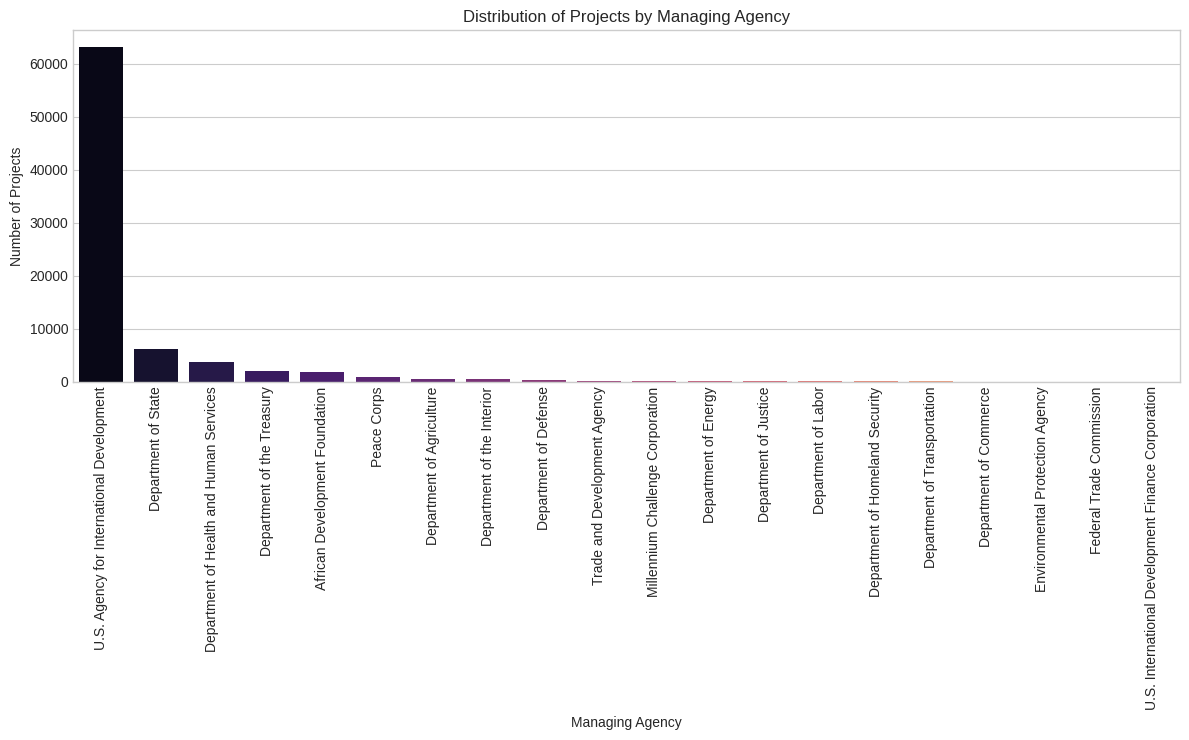

In [35]:
# --- Inspect managing agency counts ---
agency_counts = df['managing_agency_name'].value_counts()
display(agency_counts)

# --- Plot distribution ---
plt.figure(figsize=(12,7.5))
sns.barplot(x=agency_counts.index, y=agency_counts.values, palette="magma")
plt.xticks(rotation=90)
plt.title("Distribution of Projects by Managing Agency")
plt.ylabel("Number of Projects")
plt.xlabel("Managing Agency")
plt.tight_layout()
plt.show()

,count
funding_agency_name,
U.S. Agency for International Development,36101
Department of State,33644
Department of Agriculture,3078
Department of the Treasury,2022
African Development Foundation,1748
Department of Health and Human Services,878
Peace Corps,527
Department of the Interior,416
Millennium Challenge Corporation,241


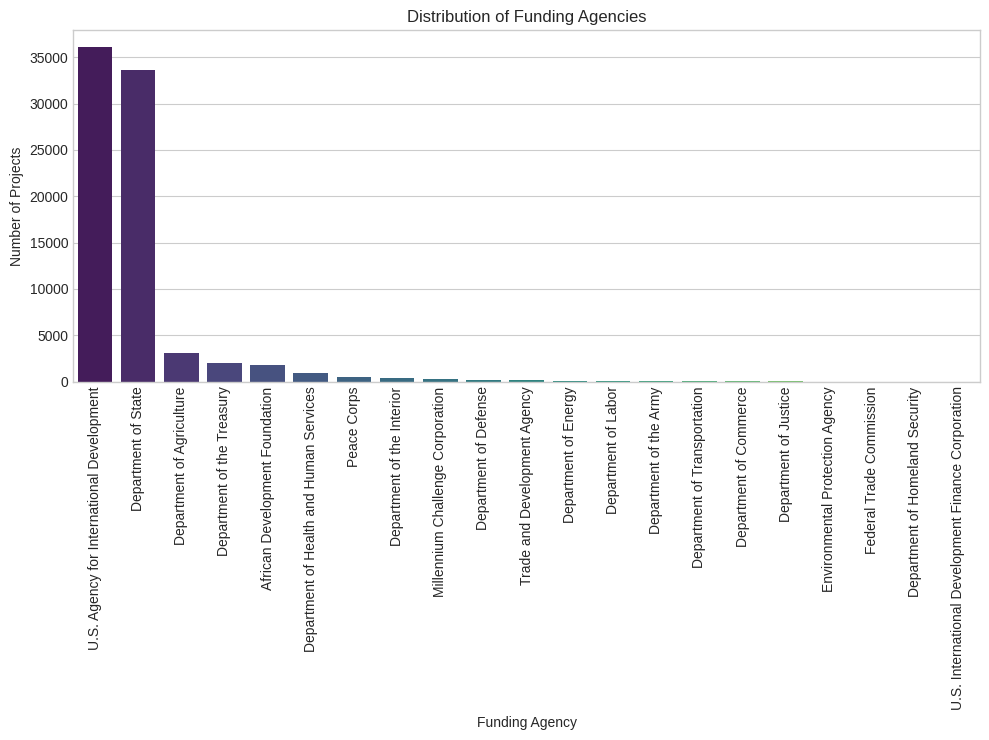

In [36]:
# Inspect funding agency name
agency_counts = df['funding_agency_name'].value_counts()
display(agency_counts)

# --- Plot distribution ---
plt.figure(figsize=(10,7.5))
sns.barplot(x=agency_counts.index, y=agency_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution of Funding Agencies")
plt.ylabel("Number of Projects")
plt.xlabel("Funding Agency")
plt.tight_layout()
plt.show()

In [37]:
# inspect us category name
df['us_category_name'].value_counts()

,count
us_category_name,
Health,29303
Program Support,21982
Economic Development,9454
Humanitarian Assistance,6220
"Democracy, Human Rights, and Governance",4094
Education and Social Services,2734
Peace and Security,2596
Environment,2547
Multi-sector,287


In [38]:
# Inspect us_sector_name
df['us_sector_name'].value_counts()

,count
us_sector_name,
Direct Administrative Costs,21860
HIV/AIDS,16596
"Protection, Assistance and Solutions",5860
Agriculture,4904
Family Planning and Reproductive Health,2730
Macroeconomic Foundation for Growth,2259
Maternal and Child Health,2213
Good Governance,2057
Malaria,2014


,count
sector,
Health,28411
Governance & Administration,22198
Humanitarian & Social Protection,7219
Agriculture & Food Security,4904
Economic Growth & Development,4315
Governance & Human Rights,4216
Infrastructure & Environment,3759
Peace & Security,2596
Education,1599


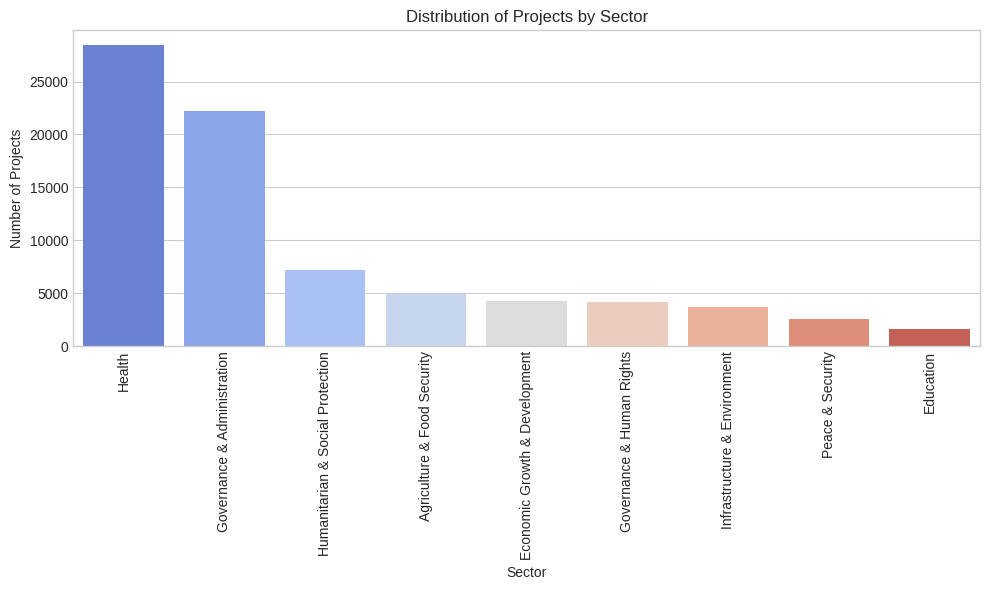

In [39]:
sector_mapping = {
    # --- Health ---
    'HIV/AIDS': 'Health',
    'Malaria': 'Health',
    'Tuberculosis': 'Health',
    'Maternal and Child Health': 'Health',
    'Family Planning and Reproductive Health': 'Health',
    'Health - General': 'Health',
    'Other Public Health Threats': 'Health',
    'Pandemic Influenza and Other Emerging Threats (PIOET)': 'Health',
    'Nutrition': 'Health',

    # --- Education ---
    'Basic Education': 'Education',
    'Higher Education': 'Education',
    'Education and Social Services - General': 'Education',

    # --- Governance & Human Rights ---
    'Rule of Law and Human Rights': 'Governance & Human Rights',
    'Good Governance': 'Governance & Human Rights',
    'Democracy, Human Rights, and Governance - General': 'Governance & Human Rights',
    'Civil Society': 'Governance & Human Rights',
    'Political Competition and Consensus-Building': 'Governance & Human Rights',
    'Monitoring and Evaluation': 'Governance & Human Rights',

    # --- Agriculture & Food Security ---
    'Agriculture': 'Agriculture & Food Security',

    # --- Economic Growth & Development ---
    'Economic Opportunity': 'Economic Growth & Development',
    'Economic Development - General': 'Economic Growth & Development',
    'Financial Sector': 'Economic Growth & Development',
    'Private Sector Competitiveness': 'Economic Growth & Development',
    'Trade and Investment': 'Economic Growth & Development',
    'Macroeconomic Foundation for Growth': 'Economic Growth & Development',
    'Policies, Regulations, and Systems': 'Economic Growth & Development',

    # --- Infrastructure & Environment ---
    'Infrastructure': 'Infrastructure & Environment',
    'Water Supply and Sanitation': 'Infrastructure & Environment',
    'Clean Productive Environment': 'Infrastructure & Environment',
    'Environment - General': 'Infrastructure & Environment',
    'Natural Resources and Biodiversity': 'Infrastructure & Environment',
    'Manufacturing': 'Infrastructure & Environment',
    'Mining and Natural Resources': 'Infrastructure & Environment',
    'Environment': 'Infrastructure & Environment',

    # --- Peace & Security ---
    'Stabilization Operations and Security Sector Reform': 'Peace & Security',
    'Counter-Terrorism': 'Peace & Security',
    'Counter-Narcotics': 'Peace & Security',
    'Conflict Mitigation and Reconciliation': 'Peace & Security',
    'Peace and Security - General': 'Peace & Security',
    'Transnational Crime': 'Peace & Security',
    'Combating Weapons of Mass Destruction (WMD)': 'Peace & Security',

    # --- Humanitarian & Social Protection ---
    'Protection, Assistance and Solutions': 'Humanitarian & Social Protection',
    'Disaster Readiness': 'Humanitarian & Social Protection',
    'Migration Management': 'Humanitarian & Social Protection',
    'Humanitarian Assistance - General': 'Humanitarian & Social Protection',
    'Social Services': 'Humanitarian & Social Protection',
    'Social Assistance': 'Humanitarian & Social Protection',

    # --- Governance & Administration ---
    'Direct Administrative Costs': 'Governance & Administration',
    'Multi-sector - Unspecified': 'Governance & Administration',
    'International Contributions': 'Governance & Administration',
    'Labor Policies and Markets': 'Governance & Administration',
}

# Apply mapping
df['sector'] = df['us_sector_name'].map(sector_mapping)
df.drop(columns='us_sector_name', inplace=True)

# --- Check distribution ---
sector_counts = df['sector'].value_counts(dropna=False)
display(sector_counts)

# --- Plot distribution ---
plt.figure(figsize=(10,6))
sns.barplot(x=sector_counts.index, y=sector_counts.values, palette="coolwarm")
plt.xticks(rotation=90, ha='center')
plt.title("Distribution of Projects by Sector")
plt.ylabel("Number of Projects")
plt.xlabel("Sector")
plt.tight_layout()
plt.show()

fiscal_year
2000      85
2001     434
2002     533
2003     581
2004     696
2005     764
2006    1298
2007    1843
2008    2071
2009    2863
2010    3258
2011    3631
2012    3612
2013    4394
2014    4428
2015    4056
2016    4173
2017    4629
2018    4218
2019    3968
2020    3739
2021    4598
2022    5287
2023    5716
2024    5764
2025    2578
Name: count, dtype: int64


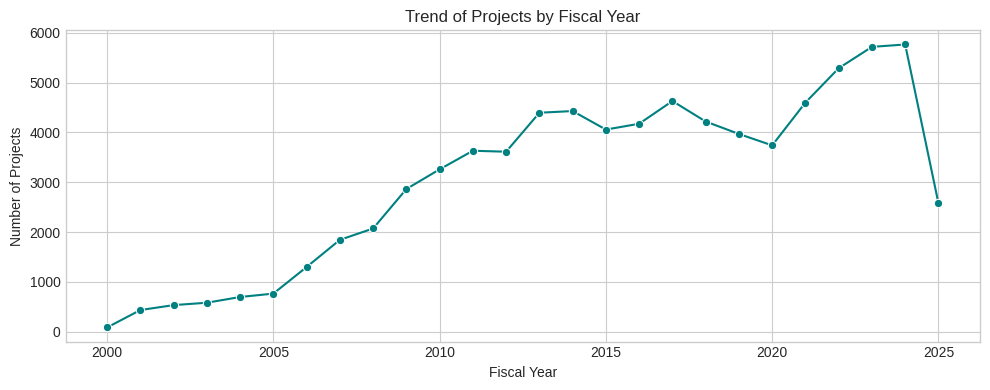

In [40]:
# --- Count projects per fiscal year ---
fy_counts = df['fiscal_year'].value_counts().sort_index()  # chronological order
print(fy_counts)

# --- Line plot ---
plt.figure(figsize=(10,4))
sns.lineplot(x=fy_counts.index, y=fy_counts.values, marker='o', color='teal')
plt.title("Trend of Projects by Fiscal Year")
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Projects")
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [41]:
# Drop us category name
df.drop(columns='us_category_name', inplace=True)

In [42]:
df = df.sort_values(['managing_agency_name', 'sector', 'fiscal_year']).reset_index(drop=True)
df.head()

,managing_agency_name,funding_agency_name,transaction_type_name,fiscal_year,constant_dollar_amount,is_refund,sector
0,African Development Foundation,African Development Foundation,Obligations,2010,16334.0,0,Agriculture & Food Security
1,African Development Foundation,African Development Foundation,Disbursements,2010,14972.0,0,Agriculture & Food Security
2,African Development Foundation,African Development Foundation,Obligations,2011,179929.0,0,Agriculture & Food Security
3,African Development Foundation,African Development Foundation,Disbursements,2011,77584.0,0,Agriculture & Food Security
4,African Development Foundation,African Development Foundation,Obligations,2011,109730.0,0,Agriculture & Food Security


# FEATURE ENGINEERING

In [43]:
# --- FEATURE ENGINEERING ---
group_cols = ['managing_agency_name', 'sector']
target_col = 'constant_dollar_amount'

# Define lag periods and rolling windows
lags = [1, 2]
rolling_windows = [3]

# --- Lag features ---
for lag in lags:
    df[f'lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)

# --- Rolling mean and std ---
for window in rolling_windows:
    df[f'rolling_mean_{window}yr'] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).mean()
    )
    df[f'rolling_std_{window}yr'] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).std()
    )

# --- Growth rate ---
df['funding_growth_rate'] = df.groupby(group_cols)[target_col].pct_change()

# --- Fill NaNs with 0 ---
feat_cols = [f'lag_{lag}' for lag in lags] + \
            [f'rolling_mean_{w}yr' for w in rolling_windows] + \
            [f'rolling_std_{w}yr' for w in rolling_windows] + \
            ['funding_growth_rate']

df[feat_cols] = df[feat_cols].fillna(0)

# Preview
df.head(10)

,managing_agency_name,funding_agency_name,transaction_type_name,fiscal_year,constant_dollar_amount,is_refund,sector,lag_1,lag_2,rolling_mean_3yr,rolling_std_3yr,funding_growth_rate
0,African Development Foundation,African Development Foundation,Obligations,2010,16334.0,0,Agriculture & Food Security,0.0,0.0,0.000000,0.000000,0.000000
1,African Development Foundation,African Development Foundation,Disbursements,2010,14972.0,0,Agriculture & Food Security,16334.0,0.0,16334.000000,0.000000,-0.083384
2,African Development Foundation,African Development Foundation,Obligations,2011,179929.0,0,Agriculture & Food Security,14972.0,16334.0,15653.000000,963.079436,11.017700
3,African Development Foundation,African Development Foundation,Disbursements,2011,77584.0,0,Agriculture & Food Security,179929.0,14972.0,70411.666667,94847.237632,-0.568808
4,African Development Foundation,African Development Foundation,Obligations,2011,109730.0,0,Agriculture & Food Security,77584.0,179929.0,90828.333333,83272.217674,0.414338
5,African Development Foundation,African Development Foundation,Disbursements,2011,43363.0,0,Agriculture & Food Security,109730.0,77584.0,122414.333333,52338.265068,-0.604821
6,African Development Foundation,African Development Foundation,Obligations,2011,12010.0,0,Agriculture & Food Security,43363.0,109730.0,76892.333333,33188.905892,-0.723036
7,African Development Foundation,African Development Foundation,Obligations,2011,1334.0,0,Agriculture & Food Security,12010.0,43363.0,55034.333333,49894.534935,-0.888926
8,African Development Foundation,African Development Foundation,Disbursements,2011,1241.0,0,Agriculture & Food Security,1334.0,12010.0,18902.333333,21845.763991,-0.069715
9,African Development Foundation,African Development Foundation,Obligations,2011,314788.0,0,Agriculture & Food Security,1241.0,1334.0,4861.666667,6190.812898,252.656728


## VANILLA ENSEMBLE REGRESSORS

In [44]:
# --- ML PIPELINES FOR RANDOM FOREST, XGBOOST, LIGHTGBM AND CATBOOST ---

# --- 1. Separate features and target ---
X = df.drop('constant_dollar_amount', axis=1)
y = np.log1p(df['constant_dollar_amount'])

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numeric features
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in x_train.columns if c not in cat_cols]

# --- 2. Column transformer for preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# --- 3. Define pipelines for each model ---
pipelines = {
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', lgb.LGBMRegressor(random_state=42))
    ]),
    'Catboost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(random_state=42, verbose=0))
    ])
}

# --- 4. Train and evaluate ---
for name, pipe in pipelines.items():
    pipe.fit(x_train, y_train)
    y_pred_log = pipe.predict(x_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²: {r2:.4f}\n")


--- RandomForest ---
MAE: 73,573.37
RMSE: 2,335,491.89
R²: 0.6399

--- XGBoost ---
MAE: 93,990.67
RMSE: 1,793,715.77
R²: 0.7876

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 63373, number of used features: 43
[LightGBM] [Info] Start training from score 10.264993
--- LightGBM ---
MAE: 98,255.71
RMSE: 2,222,033.51
R²: 0.6741

--- Catboost ---
MAE: 66,005.40
RMSE: 1,282,695.68
R²: 0.8914



## VANILLA STACKED ENSEMBLES

In [45]:
# === VANILLA STACKING REGRESSION (XGB + LGB + RIDGE) ===

# --- 1. Split features and target ---
X = df.drop('constant_dollar_amount', axis=1)
y = np.log1p(df['constant_dollar_amount'])  # Log-transform for stability

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# --- 2. Identify categorical and numeric columns ---
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in x_train.columns if c not in cat_cols]

# --- 3. Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# --- 4. Base Models ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)

# --- 5. Meta Model ---
meta_model = Ridge()

# --- 6. Stacking Regressor ---
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=meta_model,
    n_jobs=-1
)

# --- 7. Pipeline ---
stack_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stack_model)
])

# --- 8. Fit and Evaluate ---
print("Training vanilla stacking model...\n")
stack_pipe.fit(x_train, y_train)

# Predictions
y_pred_log = stack_pipe.predict(x_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# --- 9. Report ---
print("=== VANILLA STACKING ENSEMBLE ===")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

Training vanilla stacking model...

=== VANILLA STACKING ENSEMBLE ===
MAE: 75,383.22
RMSE: 1,060,092.20
R²: 0.8646


## OPTIMIZING STACKED ENSEMBLES USING RANDOMIZEDSEARCHCV

In [46]:
  # === TUNED STACKING REGRESSION (XGB + LGB + RIDGE with RandomizedSearchCV) ===

# --- 1. Split features and target ---
X = df.drop('constant_dollar_amount', axis=1)
y = np.log1p(df['constant_dollar_amount'])

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# --- 2. Identify categorical and numeric columns ---
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in x_train.columns if c not in cat_cols]

# --- 3. Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# --- 4. Base Models ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)
meta_model = Ridge()

stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=meta_model,
    n_jobs=-1
)

stack_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stack_model)
])

# --- 5. Parameter Grid for RandomizedSearchCV ---
param_grid = {
    # XGBoost
    'model__xgb__n_estimators': [100, 200, 300],
    'model__xgb__max_depth': [3, 4, 5, 6, 8],
    'model__xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__xgb__subsample': [0.6, 0.8, 1.0],
    'model__xgb__colsample_bytree': [0.6, 0.8, 1.0],

    # LightGBM
    'model__lgb__n_estimators': [100, 200, 300],
    'model__lgb__num_leaves': [20, 31, 50, 70],
    'model__lgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__lgb__subsample': [0.6, 0.8, 1.0],
    'model__lgb__colsample_bytree': [0.6, 0.8, 1.0],

    # Ridge meta-model
    'model__final_estimator__alpha': np.logspace(-3, 2, 20)
}

# --- 6. Randomized Search ---
random_search = RandomizedSearchCV(
    stack_pipe,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Running Randomized Search for Stacking Ensemble...\n")
random_search.fit(x_train, y_train)

# --- 7. Evaluation ---
best_model = random_search.best_estimator_

y_pred_log = best_model.predict(x_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n=== TUNED XGBOOST AND LGM STACKING ENSEMBLE RESULTS ===")
print(f"Best Params: {random_search.best_params_}")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")


Running Randomized Search for Stacking Ensemble...

Fitting 5 folds for each of 25 candidates, totalling 125 fits

=== TUNED XGBOOST AND LGM STACKING ENSEMBLE RESULTS ===
Best Params: {'model__xgb__subsample': 1.0, 'model__xgb__n_estimators': 200, 'model__xgb__max_depth': 4, 'model__xgb__learning_rate': 0.2, 'model__xgb__colsample_bytree': 1.0, 'model__lgb__subsample': 0.6, 'model__lgb__num_leaves': 70, 'model__lgb__n_estimators': 300, 'model__lgb__learning_rate': 0.1, 'model__lgb__colsample_bytree': 0.8, 'model__final_estimator__alpha': np.float64(0.23357214690901212)}
MAE: 71,921.93
RMSE: 1,073,122.79
R²: 0.8612


## OPTIMIZE CATBOOST AND XGBOOST USING RANDOMIZEDSEARCHCV

In [48]:
# === TUNED XGBOOST AND CATBOOST USING RANDOMIZEDSEARCHCV ===

# --- 1. TimeSeriesSplit setup ---
tscv = TimeSeriesSplit(n_splits=8)

# --- 2. Model parameter grids ---
xgb_params = {
    'model__n_estimators': [100, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [4, 6, 8],
    'model__subsample': [0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.9, 1.0],
    'model__reg_lambda': [1, 2, 5]
}

cat_params = {
    'model__iterations': [100, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 8],
    'model__l2_leaf_reg': [1, 3, 5],
    'model__bagging_temperature': [0.5, 1, 2]
}

# --- 3. Model pipelines ---
pipelines = {
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(random_state=42, verbose=0))
    ])
}

# --- 4. Randomized Search ---
param_grids = {'XGBoost': xgb_params, 'CatBoost': cat_params}

best_models = {}
for name, pipe in pipelines.items():
    print(f"\nTuning {name} with TimeSeriesSplit...\n")

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grids[name],
        n_iter=25,               # test 25 random combinations
        cv=tscv,
        scoring='r2',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X, y)
    best_models[name] = search.best_estimator_

    print(f"Best R² (CV): {search.best_score_:.4f}")
    print(f"Best Params: {search.best_params_}\n")

# --- 5. Evaluate on final holdout (last few years, e.g. 2020–2025) ---
holdout = df[df['fiscal_year'] >= 2020]
train = df[df['fiscal_year'] < 2020]

X_train = train.drop('constant_dollar_amount', axis=1)
y_train = np.log1p(train['constant_dollar_amount'])
X_test = holdout.drop('constant_dollar_amount', axis=1)
y_test = np.log1p(holdout['constant_dollar_amount'])

for name, model in best_models.items():
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {name} (Final Holdout Evaluation) ---")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²: {r2:.4f}\n")


Tuning XGBoost with TimeSeriesSplit...

Fitting 8 folds for each of 25 candidates, totalling 200 fits
Best R² (CV): 0.9941
Best Params: {'model__subsample': 0.7, 'model__reg_lambda': 5, 'model__n_estimators': 300, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}


Tuning CatBoost with TimeSeriesSplit...

Fitting 8 folds for each of 25 candidates, totalling 200 fits
Best R² (CV): 0.9948
Best Params: {'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1, 'model__iterations': 300, 'model__depth': 8, 'model__bagging_temperature': 1}

--- XGBoost (Final Holdout Evaluation) ---
MAE: 34,869.48
RMSE: 534,259.61
R²: 0.9321

--- CatBoost (Final Holdout Evaluation) ---
MAE: 33,513.60
RMSE: 510,427.57
R²: 0.9380



## OPTIMIZE CATBOOST AND XGBOOST USING OPTUNA OPTIMIZATION

In [49]:
 # === OPTUNA OPTIMIZATION FOR XGBOOST ===
# --- 1. Setup ---
tscv = TimeSeriesSplit(n_splits=8)

# === XGBOOST OPTIMIZATION ===
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**params)
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y, cv=tscv, scoring='r2', n_jobs=-1)
    return np.mean(scores)

print("=== OPTIMIZING XGBOOST ===")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=40, show_progress_bar=True)

print(f"\nBest R² (XGB CV): {study_xgb.best_value:.4f}")
print("Best Params (XGB):", study_xgb.best_params)

# --- Fit Best XGB ---
best_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(**study_xgb.best_params, objective='reg:squarederror', random_state=42, n_jobs=-1))
])
best_xgb.fit(X, y)

# === CATBOOST OPTIMIZATION ===
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': 0
    }

    model = CatBoostRegressor(**params)
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y, cv=tscv, scoring='r2', n_jobs=-1)
    return np.mean(scores)

print("\n=== OPTIMIZING CATBOOST ===")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=40, show_progress_bar=True)

print(f"\nBest R² (CatBoost CV): {study_cat.best_value:.4f}")
print("Best Params (CatBoost):", study_cat.best_params)

# --- Fit Best CatBoost ---
best_cat = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(**study_cat.best_params, random_state=42, verbose=0))
])
best_cat.fit(X, y)

# === FINAL HOLDOUT EVALUATION (2020–2025) ===
holdout = df[df['fiscal_year'] >= 2020]
train = df[df['fiscal_year'] < 2020]

X_train = train.drop('constant_dollar_amount', axis=1)
y_train = np.log1p(train['constant_dollar_amount'])
X_test = holdout.drop('constant_dollar_amount', axis=1)
y_test = np.log1p(holdout['constant_dollar_amount'])

# --- XGBOOST EVAL ---
y_pred_log_xgb = best_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)
y_true = np.expm1(y_test)

mae_xgb = mean_absolute_error(y_true, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_true, y_pred_xgb))
r2_xgb = r2_score(y_true, y_pred_xgb)

print(f"\n--- XGBOOST HOLDOUT RESULTS ---")
print(f"MAE: {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"R²: {r2_xgb:.4f}")

# --- CATBOOST EVAL ---
y_pred_log_cat = best_cat.predict(X_test)
y_pred_cat = np.expm1(y_pred_log_cat)

mae_cat = mean_absolute_error(y_true, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_true, y_pred_cat))
r2_cat = r2_score(y_true, y_pred_cat)

print(f"\n--- CATBOOST HOLDOUT RESULTS ---")
print(f"MAE: {mae_cat:,.2f}")
print(f"RMSE: {rmse_cat:,.2f}")
print(f"R²: {r2_cat:.4f}")

[I 2025-11-08 14:32:17,206] A new study created in memory with name: no-name-47fd7fd5-f330-49bb-81cc-21c0947d0092


=== OPTIMIZING XGBOOST ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-08 14:32:31,810] Trial 0 finished with value: 0.9928584956901239 and parameters: {'n_estimators': 164, 'learning_rate': 0.09147331566577942, 'max_depth': 7, 'subsample': 0.8643239509566962, 'colsample_bytree': 0.8469255555120833, 'reg_lambda': 0.9378724320695031}. Best is trial 0 with value: 0.9928584956901239.
[I 2025-11-08 14:33:26,253] Trial 1 finished with value: 0.9893390629907233 and parameters: {'n_estimators': 332, 'learning_rate': 0.013577049701725059, 'max_depth': 9, 'subsample': 0.602980099294964, 'colsample_bytree': 0.82248736931575, 'reg_lambda': 0.6341556266072359}. Best is trial 0 with value: 0.9928584956901239.
[I 2025-11-08 14:33:48,504] Trial 2 finished with value: 0.9928224665346224 and parameters: {'n_estimators': 468, 'learning_rate': 0.07817102419305656, 'max_depth': 5, 'subsample': 0.9532318917245901, 'colsample_bytree': 0.6022814013214233, 'reg_lambda': 9.202720278592457}. Best is trial 0 with value: 0.9928584956901239.
[I 2025-11-08 14:34:06,343] Tri

[I 2025-11-08 14:52:12,594] A new study created in memory with name: no-name-2c254ef5-0c62-42ca-a59f-29b32e9db4a6



=== OPTIMIZING CATBOOST ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-08 14:52:50,113] Trial 0 finished with value: 0.9948750355543422 and parameters: {'iterations': 421, 'depth': 5, 'learning_rate': 0.1424690167326815, 'l2_leaf_reg': 2.373499306933663}. Best is trial 0 with value: 0.9948750355543422.
[I 2025-11-08 14:53:29,023] Trial 1 finished with value: 0.9896975901653026 and parameters: {'iterations': 106, 'depth': 10, 'learning_rate': 0.044037615463387865, 'l2_leaf_reg': 5.323229796457006}. Best is trial 0 with value: 0.9948750355543422.
[I 2025-11-08 14:54:02,940] Trial 2 finished with value: 0.8970842242240146 and parameters: {'iterations': 135, 'depth': 9, 'learning_rate': 0.012372193571770268, 'l2_leaf_reg': 6.002930803944729}. Best is trial 0 with value: 0.9948750355543422.
[I 2025-11-08 14:54:37,572] Trial 3 finished with value: 0.9947660090169046 and parameters: {'iterations': 353, 'depth': 5, 'learning_rate': 0.15265507782031126, 'l2_leaf_reg': 1.818569663567587}. Best is trial 0 with value: 0.9948750355543422.
[I 2025-11-08 14:5

# SAVE BEST MODEL

In [50]:
import joblib

# === SAVE BEST XGBOOST PIPELINE ===
joblib.dump(best_xgb, "best_xgb_pipeline.pkl")
print("XGBoost model pipeline saved successfully as 'best_xgb_pipeline.pkl'")

# === LOAD IT LATER ===
# best_xgb_loaded = joblib.load("best_xgb_pipeline.pkl")

XGBoost model pipeline saved successfully as 'best_xgb_pipeline.pkl'
